## Nonlinear Elliptic PINN
**_Keywords: DEIM, POD-Galerkin_**

### Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)\sin(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathcal{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathcal{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathcal{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import torch.nn as nn
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import time

torch.manual_seed(0)
np.random.seed(0)

from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.#mu[0]
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## Main program

### Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.1, 10.0)]
problem.set_mu_range(mu_range)

### Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(8, DEIM=8)
reduction_method.set_tolerance(0, DEIM=0)

### Perform the offline phase

#### Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=100, sampling=EquispacedDistribution())
reduced_problem = reduction_method.offline()

#### Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [8]:
class PINNTrainerModified(Training.RONNTrainer):
    def __init__(self, ronn, data, loss_fn, optimizer, lr_scheduler=None,
                 input_normalization=None, num_epochs=10000, lr=1e-3,
                 print_every=100, starting_epoch=0, use_validation=True):

        super(PINNTrainerModified, self).__init__(
            ronn, data, loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler,
            input_normalization=input_normalization, num_epochs=num_epochs, lr=lr,
            print_every=print_every, starting_epoch=starting_epoch, use_validation=use_validation
        )

    def train(self):
        """
        Function for getting training and validation sets to pass to
        _normalize_and_train which then performs the training.
        """
        train_snap, val_snap, train_no_snap, validation_no_snap = self.data.train_validation_split()
        return self._normalize_and_train(None, None, train_snap, val_snap)

#### DEIM

In [9]:
# build matrices for computing DEIM
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
U = np.array(problem._assemble_operator_DEIM('c')).T
P = []
for idx in selected_indices:
    new_column = np.zeros(U.shape[0])
    new_column[idx] = 1
    P.append(new_column)
P = np.array(P).T
PtUinv = np.linalg.inv(P.T @ U)

In [10]:
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
dx_test = torch.tensor(np.array(assemble(problem.v*dx))[selected_indices].reshape(-1, 1))
ones_tensor = torch.ones_like(dx_test)

def DEIM_nonlinearity(u, mu):
    """
    u: torch.tensor with shape  XXX (reduced order dimension, number of samples)
    mu: torch.tensor with shape XXX (number of samples, number of parameters)
    """
    res = mu[:, 0].view(1, -1) / mu[:, 1].view(1, -1) * (torch.exp(mu[:, 1].view(1, -1) * u) - 1)
    return dx_test * res

In [11]:
input_normalization_deim = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_deim = Normalization.MinMaxNormalization()

deim_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
deim_loss = Losses.PINN_Loss(deim_net, output_normalization_deim, DEIM_func_c=DEIM_nonlinearity)
data_deim = RONNData.RONNDataLoader(deim_net, validation_proportion=0.0, 
                                    num_without_snapshots=0)
optimizer_deim = torch.optim.Adam(deim_net.parameters(), lr=0.001)
scheduler_deim = torch.optim.lr_scheduler.ExponentialLR(optimizer_deim, 0.99999)

deim_trainer = PINNTrainerModified(
    deim_net, data_deim, deim_loss, optimizer_deim, scheduler_deim,
    input_normalization_deim, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    deim_net, data_deim, deim_trainer, optimizer_deim
)

In [12]:
deim_trainer.train()

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.65it/s, Loss(training)=0.0952]


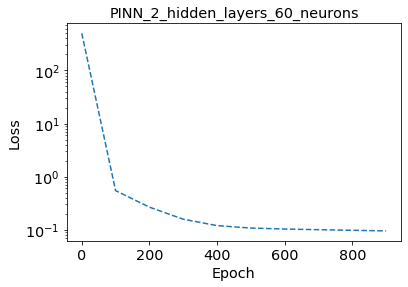

In [13]:
fig, ax = Training.plot_loss(deim_trainer, deim_net)

#### NEIM

In [14]:
# Step 1
# Get nonlinear_terms, parameters, N0
nonlinear_terms = np.zeros((len(reduction_method.training_set), len(reduction_method.training_set), reduced_problem.N)) # f_NEIM
params = np.array(reduction_method.training_set) # mu

solutions = []
Basis_Matrix = np.array([v.vector()[:] for v in reduced_problem.basis_functions]) # V.T

for mu in reduction_method.training_set:
    problem.set_mu(mu)
    solution = problem.solve()
    solutions.append(np.array(problem._solution.vector()[:]))

dx_vector = np.array(assemble(problem.v*dx)).reshape(-1)
    
for i, mu in enumerate(reduction_method.training_set):    
    for j, solution in enumerate(solutions):
        nonlinear_terms[i, j] = (Basis_Matrix @ (mu[0] / mu[1] * (np.exp(mu[1] * solution) - 1).reshape(-1) * dx_vector).reshape(-1, 1)).reshape(-1)
        
solutions_ = []
for sol in solutions:
    F = Function(V)
    F.vector()[:] = sol
    solutions_.append(np.array(reduced_problem.project(F).vector()[:]))
solutions = np.array(solutions_) # ro_sols

print(nonlinear_terms.shape, params.shape, Basis_Matrix.T.shape, solutions.shape)
# Note the correspondence with the NEIM function inputs:
#     ro_sols <--> solutions
#     f_NEIM  <--> nonlinear_terms
#     mu      <--> params
#     V       <--> Basis_Matrix.T

(100, 100, 8) (100, 2) (1187, 8) (100, 8)


In [15]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2).mean()

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 10)
        self.fc2 = nn.Linear(10, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
    
def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    WEIGHTS = np.zeros((mu.shape[0], mu.shape[0]))
    for i in range(mu.shape[0]):
        for j in range(mu.shape[0]):
            if np.linalg.norm(mu[i] - mu[j]) <= 1.75:
                WEIGHTS[i, j] = 1
    #WEIGHTS = np.array([[(abs(i - j) <= 1)/(1+10000*abs(i-j)**2) for j in range(mu.shape[0])] for i in range(mu.shape[0])])
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.array([np.sum(f_NEIM[i, i]**2) for i in range(NUM_PARAMS)])
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    mse_weights = torch.tensor(WEIGHTS[idx].reshape(-1, 1))
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols).float()
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])])).float()
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = weighted_mse_loss(output, y_data, mse_weights)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1))#, dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            if i == j:
                net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
                numerator += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], net_u_mu)
                denominator += WEIGHTS[i, j] * np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1).float()).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        # Compute Errors and Choose New Parameter
        errors = np.array([np.sum((f_NEIM[i, i] - approx(ro_sols[i], i))**2) for i in range(NUM_PARAMS)])
        print("Mean Already Selected Error:", np.mean(errors[np.array(selected_indices)]))
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        mse_weights = torch.tensor(WEIGHTS[mu_2_idx].reshape(-1, 1))
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        previous_y_data = np.copy(y_data)
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]))#, dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2
        
        for j in range(f_NEIM.shape[1]):
             y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data).float()#, dtype=torch.double)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = weighted_mse_loss(output, y_data, mse_weights)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets))#, dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS = np.zeros((num_nets, num_nets))#, dtype=np.double)
            RHS = np.zeros((num_nets, 1))#, dtype=np.double)

            for j in range(NUM_PARAMS):
                if i == j:
                    nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]
                    for k1 in range(num_nets):
                        RHS[k1] += WEIGHTS[i, j] * np.dot(f_NEIM[i, j], nets_u_mu[k1])
                        for k2 in range(num_nets):
                            LHS[k1, k2] += WEIGHTS[i, j] * np.dot(nets_u_mu[k1], nets_u_mu[k2])

            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='linear').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1).float()).view(-1).detach().numpy()
        return s.reshape(-1)
    
    return NEIM_approximation, selected_indices, trained_networks, mu, thetas

In [16]:
# train NEIM
NEIM_approximation, selected_indices, trained_networks, mu, thetas = NEIM(solutions, nonlinear_terms, params, Basis_Matrix.T, max_modes=8)

99 Max Error: 4.63272306215528 Mean Error: 1.59200824235469
0 0.02322600824292749
100 0.001817358006020271
200 7.347403725862733e-05
300 3.109837526200643e-06
400 2.2325480040308323e-06
500 2.2087733286113576e-06
600 2.185418507902881e-06
700 2.1599823800855233e-06
800 2.132660620777216e-06
900 2.1036407489205542e-06
1000 2.07307905446541e-06
1100 2.041129755427917e-06
1200 2.007924976714648e-06
1300 1.973601953304538e-06
1400 1.9382958632085946e-06
1500 1.9021127236129586e-06
1600 1.8651903617650235e-06
1700 1.8276242555070876e-06
1800 1.7895233638826057e-06
1900 1.750990162020516e-06
2000 1.7121189334453126e-06
2100 1.6729981257779248e-06
2200 1.6337096885288282e-06
2300 1.594336350236869e-06
2400 1.5549327326946916e-06
2500 1.515580248478976e-06
2600 1.4763430760511565e-06
2700 1.4372564262754573e-06
2800 1.3983848406531885e-06
2900 1.359750067921762e-06
3000 1.321401895415797e-06
3100 1.2833713589166518e-06
3200 1.2456759084211732e-06
3300 1.208334765134822e-06
3400 1.1713602930951

8900 1.0068180110178737e-07
9000 9.702237328941543e-08
9100 9.244355603402893e-08
9200 8.896383245127899e-08
9300 8.578368593250077e-08
9400 8.306189386604947e-08
9500 8.059572987067013e-08
9600 7.829237982925896e-08
9700 7.62957257879112e-08
9800 7.447163453591642e-08
9900 7.27686293925528e-08

Finding theta...
Mean Already Selected Error: 4.055842672392807e-07
9 Max Error: 0.00154730097532474 Mean Error: 0.0003177538686602779
0 0.004354523880901979
100 0.001448737665355111
200 0.001049687739438525
300 0.0007518679226905078
400 0.0006825098583306044
500 0.0006704094814367068
600 0.0006608238199564198
700 0.0006507334710647683
800 0.0006398967416589585
900 0.0006280647652693005
1000 0.000614831825098463
1100 0.0005994740022515543
1200 0.0005808442908880096
1300 0.0005577666159281591
1400 0.0005292943232052494
1500 0.0004943496405621772
1600 0.00045199337476447
1700 0.0004019691587386376
1800 0.00034529668938901634
1900 0.000284628491933745
2000 0.00022409838820721005
2100 0.00016830653

7800 1.2953053585042507e-05
7900 1.2675229239184904e-05
8000 1.2389582718666734e-05
8100 1.20924377337564e-05
8200 1.1787385131368788e-05
8300 1.1472369808543937e-05
8400 1.1151990910232002e-05
8500 1.0829555069036267e-05
8600 1.0497886736740015e-05
8700 1.0168938816743633e-05
8800 9.860274367573529e-06
8900 9.514604093996405e-06
9000 9.191569319917658e-06
9100 8.875237309740325e-06
9200 8.572979994107e-06
9300 8.273229882580501e-06
9400 7.991422586912656e-06
9500 7.717112110405822e-06
9600 7.4478127591026675e-06
9700 7.181078157563192e-06
9800 6.930288077993118e-06
9900 6.693518238995999e-06

Finding theta...
Mean Already Selected Error: 3.381658941978018e-07
95 Max Error: 4.876436688806359e-05 Mean Error: 5.761337382229103e-06
0 0.01595745979262837
100 0.006739515490656913
200 0.006360220359565574
300 0.005975299119636474
400 0.0054525745378850845
500 0.004970122376210422
600 0.004667045579672049
700 0.004523409184455813
800 0.004464958041207865
900 0.0044389111392229095
1000 0.00442

In [17]:
def NonlinearityApprox(new_sol, new_mu, num_modes=-1):
    if num_modes == -1:
        num_modes = len(trained_networks)

    thetas_ = interpolate.griddata(mu, thetas, new_mu, method='linear').reshape(-1)
    if True in np.isnan(thetas_):
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
    s = 0
    for i, net in enumerate(trained_networks[:num_modes]):
        s += thetas_[i] * net(new_sol.view(1, -1).float()).view(-1)
    return s.reshape(-1)

In [18]:
from rbnics.backends.basic.wrapping.delayed_transpose import DelayedTranspose
from rbnics.backends.online import OnlineFunction, OnlineVector
from rbnics.backends.common.time_series import TimeSeries
from rbnics.backends.dolfin.parametrized_tensor_factory import ParametrizedTensorFactory
from rbnics.backends.dolfin.evaluate import evaluate

class Approx_PINN_Loss(Losses.RONN_Loss_Base):
    def __init__(self, ronn, normalization=None, beta=1., mu=None):
        super(Approx_PINN_Loss, self).__init__(ronn, mu)
        self.operators = None
        self.proj_snapshots = None
        self.T0_idx = None
        self.normalization = normalization
        if self.normalization is None:
            self.normalization = IdentityNormalization()

        self.beta = beta

        # if time dependent, we need the neural net to compute time derivative
        self.time_dependent = False

    def name(self):
        return "Approx_PINN"

    def _compute_operators(self):
        self.operators_initialized = True

        #self.operators = self.ronn.get_operator_matrices(self.mu)
        self.operators = self.ronn.get_reduced_operator_matrices(self.mu)

        if not self.normalization.initialized:
            self.normalization(self.ronn.get_projected_snapshots())

    def set_mu(self, mu):
        self.mu = mu
        self.operators_initialized = False

    def __call__(self, **kwargs):
        pred = kwargs["prediction_no_snap"]
        if not self.operators_initialized:
            self._compute_operators()

        pred = self.normalization(pred.T, normalize=False).T

        ##### 1st equation in system #####
        res1 = 0.0

        # these two could be combined when both not None
        res1 -= self.operators['f']
        self.operators['c'] = torch.zeros_like(self.operators['f'])
        for i, mu in enumerate(kwargs["input_normalization"](kwargs["normalized_mu"], normalize=False)):                
            mu = np.array(mu)
            sol = pred[i].float()
            C = NonlinearityApprox(sol, mu).view(-1, 1).double()#.detach()
            self.operators['c'][i] = C[None, :, :]

        res1 += self.operators['c']
        res1 += torch.matmul(self.operators['a'], pred[:, :, None].double())

        loss1 = torch.mean(torch.sum(res1**2, dim=1)) if type(res1) is not float else res1
        
        val = loss1
        self.value = val.item()

        return val

    def reinitialize(self, mu):
        normalization = self.normalization
        beta = self.beta
        return Approx_PINN_Loss(self.ronn, normalization, beta, mu)

In [19]:
torch.manual_seed(42)

input_normalization_neim = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_neim = Normalization.MinMaxNormalization()

neim_net  = NN.RONN("Approx_PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
neim_loss = Approx_PINN_Loss(neim_net, output_normalization_neim)
data_neim = RONNData.RONNDataLoader(neim_net, validation_proportion=0.0, 
                                    num_without_snapshots=0)
optimizer_neim = torch.optim.Adam(neim_net.parameters(), lr=0.001)
scheduler_neim = torch.optim.lr_scheduler.ExponentialLR(optimizer_neim, 0.99999)

neim_trainer = PINNTrainerModified(
    neim_net, data_neim, neim_loss, optimizer_neim, scheduler_neim,
    input_normalization_neim, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    neim_net, data_neim, neim_trainer, optimizer_neim
)

In [20]:
neim_trainer.train()

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|███████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.88it/s, Loss(training)=0.00134]


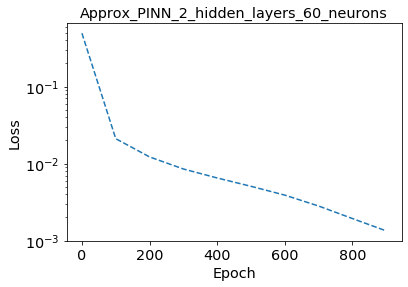

In [21]:
fig, ax = Training.plot_loss(neim_trainer, neim_net)

### Perform an error analysis

#### Reduction Method Error Analysis

In [8]:
reduction_method.initialize_testing_set(100, DEIM=60)

False

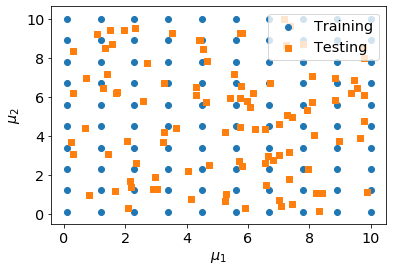

In [13]:
plt.scatter(np.array(reduction_method.training_set)[:, 0], np.array(reduction_method.training_set)[:, 1], label="Training")
plt.scatter(np.array(reduction_method.testing_set)[:, 0], np.array(reduction_method.testing_set)[:, 1], marker="s", label="Testing")
plt.xlabel("$\mu_1$")
plt.ylabel("$\mu_2$")
plt.legend()
plt.savefig(f'./Paper Figures/train_test_points_nonlinear_elliptic_pinn.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/train_test_points_nonlinear_elliptic_pinn_x_train.npy", 'wb') as file_obj:
    np.save(file_obj, np.array(reduction_method.training_set)[:, 0])
with open(f"./Paper Data/train_test_points_nonlinear_elliptic_pinn_y_train.npy", 'wb') as file_obj:
    np.save(file_obj, np.array(reduction_method.training_set)[:, 1])
with open(f"./Paper Data/train_test_points_nonlinear_elliptic_pinn_x_test.npy", 'wb') as file_obj:
    np.save(file_obj, np.array(reduction_method.testing_set)[:, 0])
with open(f"./Paper Data/train_test_points_nonlinear_elliptic_pinn_y_test.npy", 'wb') as file_obj:
    np.save(file_obj, np.array(reduction_method.testing_set)[:, 1])
plt.show()

In [24]:
test_mu = torch.tensor(reduction_method.testing_set)

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.204255e+00
  2 SNES Function norm 6.340893e-01
  3 SNES Function norm 1.172138e-01
  4 SNES Function norm 8.128367e-03
  5 SNES Function norm 4.222057e-05
  6 SNES Function norm 1.119995e-09
  7 SNES Function norm 4.190770e-15
PETSc SNES solver converged in 7 iterations with convergence reason 2.


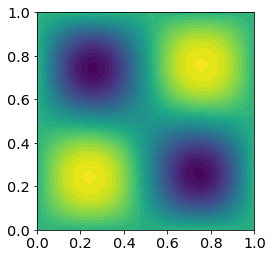

In [25]:
online_mu = (5.5, 5.5)
problem.set_mu(online_mu)
solution = problem.solve()
plot(solution)

#### DEIM PINN Error Analysis

In [26]:
errors = ErrorAnalysis.error_analysis_fixed_net(
    deim_net, test_mu, input_normalization_deim, output_normalization_deim, euclidean=True, relative=True
)

0:  |F(x)| = 3.7113; step 0.315431
1:  |F(x)| = 1.35476; step 0.560027
2:  |F(x)| = 0.0238292; step 1
3:  |F(x)| = 0.000356607; step 1
4:  |F(x)| = 6.60501e-06; step 1
5:  |F(x)| = 1.93703e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.19453; step 0.405699
1:  |F(x)| = 1.0759; step 1
2:  |F(x)| = 0.154135; step 1
3:  |F(x)| = 0.00489161; step 1
4:  |F(x)| = 1.95965e-05; step 1
5:  |F(x)| = 2.97971e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.5977; step 0.338203
1:  |F(x)| = 2.60749; step 0.266279
2:  |F(x)| = 0.745987; step 1
3:  |F(x)| = 0.0892175; step 1
4:  |F(x)| = 0.00165594; step 1
5:  |F(x)| = 7.21146e-06; step 1
6:  |F(x)| = 1.74538e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.67923; step 0.314551
1:  |F(x)| = 1.62034; step 0.491396
2:  |F(x)| = 0.0542799; step 1
3:  |F(x)| = 0.00091802; step 1
4:  |F(x)| = 2.57231e-05; step 1
5:  |F(x)| = 1.24405e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.8

scipy solver converged in 6 iterations.
0:  |F(x)| = 3.62511; step 0.330254
1:  |F(x)| = 1.96213; step 0.438307
2:  |F(x)| = 0.187185; step 1
3:  |F(x)| = 0.00592472; step 1
4:  |F(x)| = 2.43994e-05; step 1
5:  |F(x)| = 1.98683e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.129999; step 1
1:  |F(x)| = 0.00869108; step 1
2:  |F(x)| = 0.00111936; step 1
3:  |F(x)| = 0.000152227; step 1
4:  |F(x)| = 2.05903e-05; step 1
5:  |F(x)| = 2.78327e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.17759; step 1
1:  |F(x)| = 0.00521881; step 1
2:  |F(x)| = 0.000232946; step 1
3:  |F(x)| = 1.14925e-05; step 1
4:  |F(x)| = 5.70976e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 0.182288; step 1
1:  |F(x)| = 0.00557986; step 1
2:  |F(x)| = 0.000260192; step 1
3:  |F(x)| = 1.33879e-05; step 1
4:  |F(x)| = 6.9441e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 2.77405; step 0.488188
1:  |F(x)| = 0.481408; step 1
2:  |F(x)| = 0.038829

5:  |F(x)| = 1.26348e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.71113; step 0.313171
1:  |F(x)| = 2.62129; step 0.284153
2:  |F(x)| = 0.613922; step 1
3:  |F(x)| = 0.0578213; step 1
4:  |F(x)| = 0.00060051; step 1
5:  |F(x)| = 1.44781e-05; step 1
6:  |F(x)| = 1.388e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.73048; step 0.317198
1:  |F(x)| = 2.39002; step 0.328699
2:  |F(x)| = 0.762101; step 1
3:  |F(x)| = 0.101114; step 1
4:  |F(x)| = 0.00195843; step 1
5:  |F(x)| = 3.88696e-05; step 1
6:  |F(x)| = 2.78598e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 2.0883; step 0.44722
1:  |F(x)| = 0.160969; step 1
2:  |F(x)| = 0.00644975; step 1
3:  |F(x)| = 0.000328672; step 1
4:  |F(x)| = 1.41905e-05; step 1
5:  |F(x)| = 3.51264e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.72833; step 0.316567
1:  |F(x)| = 2.28246; step 0.353379
2:  |F(x)| = 0.532785; step 1
3:  |F(x)| = 0.052703; step 1
4:  |F(x)| = 0.000337

  1 SNES Function norm 1.035763e+00
  2 SNES Function norm 2.787936e-01
  3 SNES Function norm 3.308945e-02
  4 SNES Function norm 5.527576e-04
  5 SNES Function norm 1.597361e-07
  6 SNES Function norm 1.413338e-14
PETSc SNES solver converged in 6 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.230132e+00
  2 SNES Function norm 6.463914e-01
  3 SNES Function norm 1.076079e-01
  4 SNES Function norm 6.643570e-03
  5 SNES Function norm 2.706344e-05
  6 SNES Function norm 4.393947e-10
PETSc SNES solver converged in 6 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358259e+00
  2 SNES Function norm 1.219211e+00
  3 SNES Function norm 1.093395e+00
  4 SNES Function norm 9.805021e-01
  5 SNES Function norm 7.352479e-01
  6 SNES Function norm 3.633288e-01
  7 SNES Function norm 5.806507e-02
  8 SNES Function norm 2.115046e-03
  9 SNES Function norm 2.955530e-06
  10 SNES Function norm 5.6375

  6 SNES Function norm 1.540032e-12
PETSc SNES solver converged in 6 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.991544e-02
  2 SNES Function norm 1.210991e-03
  3 SNES Function norm 3.050316e-07
  4 SNES Function norm 2.135524e-14
PETSc SNES solver converged in 4 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 4.558545e-02
  2 SNES Function norm 3.455113e-04
  3 SNES Function norm 2.091317e-08
  4 SNES Function norm 4.222942e-15
PETSc SNES solver converged in 4 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.724261e-01
  2 SNES Function norm 2.894000e-02
  3 SNES Function norm 3.477942e-04
  4 SNES Function norm 5.049977e-08
  5 SNES Function norm 3.978748e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.944535e-01
  2 SNES Function norm 1.492520e

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.323547e+00
  2 SNES Function norm 1.010812e+00
  3 SNES Function norm 8.046657e-01
  4 SNES Function norm 2.004004e-01
  5 SNES Function norm 2.044540e-02
  6 SNES Function norm 2.517885e-04
  7 SNES Function norm 3.901715e-08
  8 SNES Function norm 4.247513e-15
PETSc SNES solver converged in 8 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358927e+00
  2 SNES Function norm 1.221085e+00
  3 SNES Function norm 1.096025e+00
  4 SNES Function norm 9.831261e-01
  5 SNES Function norm 8.818223e-01
  6 SNES Function norm 6.342723e-01
  7 SNES Function norm 2.651573e-01
  8 SNES Function norm 3.684054e-02
  9 SNES Function norm 9.512242e-04
  10 SNES Function norm 6.488098e-07
  11 SNES Function norm 2.941126e-13
PETSc SNES solver converged in 11 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358655e+00
  2 SNES Function norm 1.22

  8 SNES Function norm 7.394663e-04
  9 SNES Function norm 3.578187e-07
  10 SNES Function norm 8.175937e-14
PETSc SNES solver converged in 10 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.359186e+00
  2 SNES Function norm 1.222099e+00
  3 SNES Function norm 1.098018e+00
  4 SNES Function norm 9.858859e-01
  5 SNES Function norm 8.848998e-01
  6 SNES Function norm 6.700181e-01
  7 SNES Function norm 3.894123e-01
  8 SNES Function norm 7.142108e-02
  9 SNES Function norm 3.510390e-03
  10 SNES Function norm 9.092290e-06
  11 SNES Function norm 6.005390e-11
PETSc SNES solver converged in 11 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.087751e+00
  2 SNES Function norm 5.564849e-01
  3 SNES Function norm 1.159745e-01
  4 SNES Function norm 9.178735e-03
  5 SNES Function norm 6.241566e-05
  6 SNES Function norm 2.847036e-09
  7 SNES Function norm 3.954032e-15
PETSc SNES solver converg

  2 SNES Function norm 5.272167e-03
  3 SNES Function norm 9.840573e-06
  4 SNES Function norm 3.394480e-11
PETSc SNES solver converged in 4 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.851399e-01
  2 SNES Function norm 2.213611e-02
  3 SNES Function norm 2.930570e-04
  4 SNES Function norm 5.037080e-08
  5 SNES Function norm 4.367636e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
################################## PINN N = 8 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.007145281076038995	0.007145638262199702	1.8463614901969575e-05
mean	0.061178670227732816	0.06339979562267008	0.00587628243690023
max	0.13919020146308078	0.13918452201510703	0.01938134421315476


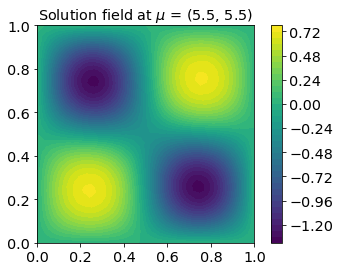

In [27]:
ErrorAnalysis.plot_solution(
    deim_net, online_mu, input_normalization_deim, output_normalization_deim, filetype="pdf"
)

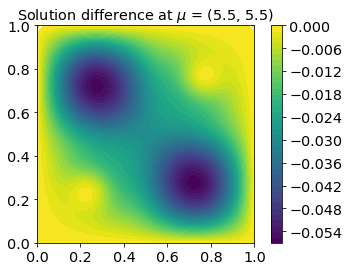

In [28]:
ErrorAnalysis.plot_solution_difference(
    deim_net, online_mu, input_normalization_deim, output_normalization_deim, colorbar=True, filetype="pdf"
)

#### NEIM PINN Error Analysis

In [29]:
errors = ErrorAnalysis.error_analysis_fixed_net(
    neim_net, test_mu, input_normalization_neim, output_normalization_neim, euclidean=True, relative=True
)

############################## Approx_PINN N = 8 ###############################
ERROR	NN-HF			NN-RO			RO-HF
min	0.002387164023892202	0.0031188603824905082	1.8463614901969575e-05
mean	0.009549615193207153	0.011716485927947025	0.00587628243690023
max	0.02630661181547349	0.026186260786721437	0.01938134421315476


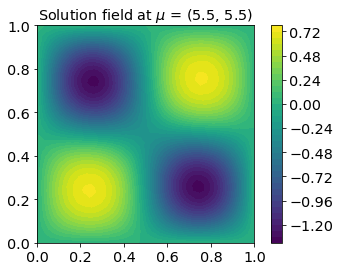

In [30]:
ErrorAnalysis.plot_solution(
    neim_net, online_mu, input_normalization_neim, output_normalization_neim, filetype="pdf"
)

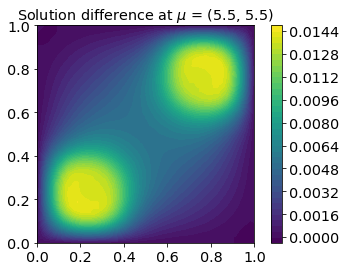

In [31]:
ErrorAnalysis.plot_solution_difference(
    neim_net, online_mu, input_normalization_neim, output_normalization_neim, colorbar=True, filetype="pdf"
)